# Выполним аналитику датасета.

При предпросмотре данных, было определено, что для некоторых отрывков "start" > "end", что не является логичным. Время конца отрывка не может быбть раньше времени его начала, поэтому сначала необходимо исследовать и исправить таргеты в ```test_labels.json``` и ```train_labels.json```. Всего нам дано 80 + 45 = 125 видео, определим видео с неверными временными метками заставки и исправим их на верные. Было замечено, что у таких видео необходимо время начала уменьшить на 1 минуту.

In [1]:
#импорт базовых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import json
import os
from datetime import datetime, timedelta
import seaborn as sns

In [2]:
#алгоритм поиска неверных временных меток

#подгрузим данные
project_dir = '/kaggle/input/vk-series-data/'
test_target = os.path.join(project_dir, 'test_labels.json')
train_target = os.path.join(project_dir, 'train_labels.json')

with open(test_target) as f:
    test_target_dict = json.load(f)

with open(train_target) as f:
    train_target_dict = json.load(f)

def process_bad_times(dictionary):

    for description in dictionary.values():
        start_time = datetime.strptime(description["start"], "%H:%M:%S")
        end_time = datetime.strptime(description["end"], "%H:%M:%S")
        if start_time > end_time:
            start_time = start_time - timedelta(minutes=1)
            description["start"] = start_time.strftime("%H:%M:%S")

process_bad_times(test_target_dict)
process_bad_times(train_target_dict)

Теперь можно изучать статистические параметры времени заставок

In [3]:
# Загрузим данные в датафрейм
df = pd.concat([pd.DataFrame(test_target_dict), pd.DataFrame(train_target_dict)], axis = 1)
df = df.T
df["start"] = pd.to_datetime(df["start"], format = "%H:%M:%S").dt.time
df["end"] = pd.to_datetime(df["end"], format = "%H:%M:%S").dt.time
df

,url,name,start,end
-220020068_456249220,https://vkvideo.ru/video-220020068_456249220,"24 часа. 2 сезон, 16 серия",00:00:05,00:00:16
-220020068_456249373,https://vkvideo.ru/video-220020068_456249373,"24 часа. 8 сезон, 18 серия",00:00:05,00:00:16
-220020068_456249231,https://vkvideo.ru/video-220020068_456249231,"24 часа. 3 сезон, 1 серия",00:00:05,00:00:16
-220020068_456255339,https://vkvideo.ru/video-220020068_456255339,Анатомия скандала. 1 сезон. 2 серия.,00:00:10,00:00:20
-220020068_456249284,https://vkvideo.ru/video-220020068_456249284,"24 часа. 5 сезон, 4 серия",00:00:05,00:00:16
...,...,...,...,...
-220020068_456249719,https://vkvideo.ru/video-220020068_456249719,"Бывaeт и xyжe. 2 сезон ,6 серия",00:00:06,00:00:10
-220020068_456255400,https://vkvideo.ru/video-220020068_456255400,"Баскетс. 3 сезон, 3 серия",00:00:17,00:00:22
-220020068_456256446,https://vkvideo.ru/video-220020068_456256446,"Бойцовская ночь: Афера на миллион. 1 сезон, 4 ...",00:04:41,00:05:25
-220020068_456255401,https://vkvideo.ru/video-220020068_456255401,"Баскетс. 3 сезон, 4 серия",00:00:17,00:00:22


In [4]:
# спарсим необходимую информацию о каждом видео

input_dir = '/kaggle/input/vk-series-data/'

test_path = os.path.join(project_dir, 'data_test_short/data_test_short/')
train_path = os.path.join(project_dir, 'data_train_short/data_train_short/')

videos_info = {}

def scan_directories(root_path):
    
    subfolders = [f.name for f in os.scandir(root_path) if f.is_dir()]

    for folder in subfolders:
        for file in os.listdir(root_path + folder):
            cap = cv2.VideoCapture(root_path + folder + "/" + file)
            
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            fps = cap.get(cv2.CAP_PROP_FPS)
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
            duration_sec = frame_count / fps
            duration = timedelta(seconds=int(duration_sec))

            videos_info[folder] = [frame_count, fps, width, height, duration_sec]
            
scan_directories(test_path)
scan_directories(train_path)


#сконкатенируем информацию из видео и информацию из json по накваниям колонок
df_videos = pd.DataFrame(videos_info).T
df_videos.columns = ["frame_count", "fps","width","height","duration_sec"]

df = df.join(df_videos, how="outer")

In [5]:
#преобразую датафрейм для дальнейших исследований и выделю некоторые важные характеристики видео

df['frame_count'] = df['frame_count'].astype('float') #количество кадров в видео
df['fps'] = df['fps'].astype('float') # количетво кадров в секунду в видео
df['width'] = df['width'].astype('float') # ширина кадра
df['height'] = df['height'].astype('float') # высота кадра
df['duration_sec'] = df['duration_sec'].astype('float') # продолжительность видео в секундах
df['start'] = df['start'].apply(lambda x: x.hour*3600 + x.minute*60 + x.second) # секунда с которой начинается заставка
df['end'] = df['end'].apply(lambda x: x.hour*3600 + x.minute*60 + x.second) # секунда на которой заканчивается заставка
df.iloc[60, 3] = 487 # исправил 1 некорректное значение
df['frames_intro'] = df['end'] - df['start']  # длительность заставки
df['rel_start'] = df["start"] / df["duration_sec"] # относительное время начала заставки
df["rel_end"] = df["end"] / df["duration_sec"] # относительное время окончания заставки
df["rel_length"] = df["frames_intro"] / df["frame_count"] # относительное время длины заставки

In [6]:
df.describe()

,start,end,frame_count,fps,width,height,duration_sec,frames_intro,rel_start,rel_end,rel_length
count,125.000000,125.000000,125.000000,125.000000,125.00000,125.000000,125.000000,125.00000,125.000000,125.000000,125.000000
mean,100.040000,112.976000,55334.256000,24.217773,943.16800,530.688000,2287.213229,12.93600,0.042488,0.047876,0.000223
std,135.770763,143.791149,18015.071609,0.431973,197.15021,109.862701,747.212550,13.56094,0.052824,0.055112,0.000190
min,0.000000,8.000000,30600.000000,23.975442,480.00000,360.000000,1223.993322,2.00000,0.000000,0.005150,0.000054
25%,5.000000,16.000000,36750.000000,23.976102,852.00000,480.000000,1510.960000,5.00000,0.002314,0.007200,0.000128
50%,58.000000,67.000000,61499.000000,23.976669,852.00000,480.000000,2565.055067,10.00000,0.022594,0.031480,0.000157
75%,117.000000,140.000000,65503.000000,24.000744,852.00000,480.000000,2704.026278,11.00000,0.068206,0.073880,0.000241
max,708.000000,749.000000,97281.000000,25.000777,1920.00000,1080.000000,4057.339522,87.00000,0.305573,0.323269,0.001031


In [7]:
df

,url,name,start,end,frame_count,fps,width,height,duration_sec,frames_intro,rel_start,rel_end,rel_length
-220020068_456239859,https://vkvideo.ru/video-220020068_456239859,"3вeздный пyть: Пикap. 3 сезон, 10 серия",15,28,90888.0,24.000034,1920.0,1080.0,3786.994589,13,0.003961,0.007394,0.000143
-220020068_456241671,https://vkvideo.ru/video-220020068_456241671,"Амepикaнcкий вaндaл. 1 сезон, 3 серия",167,190,53203.0,23.975581,852.0,480.0,2219.049444,23,0.075257,0.085622,0.000432
-220020068_456241671,https://vkvideo.ru/video-220020068_456241671,"Амepикaнcкий вaндaл. 1 сезон, 3 серия",167,190,53203.0,23.975581,852.0,480.0,2219.049444,23,0.075257,0.085622,0.000432
-220020068_456241672,https://vkvideo.ru/video-220020068_456241672,"Амepикaнcкий вaндaл. 1 сезон, 4 серия",171,195,48552.0,23.975539,852.0,480.0,2025.064000,24,0.084442,0.096293,0.000494
-220020068_456241673,https://vkvideo.ru/video-220020068_456241673,"Амepикaнcкий вaндaл. 1 сезон, 5 серия",112,137,47472.0,23.975528,852.0,480.0,1980.019000,25,0.056565,0.069191,0.000527
...,...,...,...,...,...,...,...,...,...,...,...,...,...
-220020068_456257136,https://vkvideo.ru/video-220020068_456257136,Белые линии. 1 сезон. 7 серия.,363,371,83137.0,25.000629,852.0,480.0,3325.396278,8,0.109160,0.111566,0.000096
-220020068_456257137,https://vkvideo.ru/video-220020068_456257137,Белые линии. 1 сезон. 8 серия.,113,120,80987.0,25.000309,852.0,480.0,3239.440000,7,0.034883,0.037043,0.000086
-220020068_456257137,https://vkvideo.ru/video-220020068_456257137,Белые линии. 1 сезон. 8 серия.,113,120,80987.0,25.000309,852.0,480.0,3239.440000,7,0.034883,0.037043,0.000086
-220020068_456257139,https://vkvideo.ru/video-220020068_456257139,Белые линии. 1 сезон. 1 серия.,245,253,84145.0,25.000622,852.0,480.0,3365.716278,8,0.072793,0.075170,0.000095


# Датафрейм для исследования готов. Теперь переходим к исследованию.

Можем сделать несколько выводов из предпоготки данных

1) Все значения в датафрейме не пустые (не NaN)
2) Для некоторых видео характеристик видео будут присутствовать выбросы
3) В среднем заставка находится в 1й четверти в видео (сериале) - в первые 25% времени

In [8]:
df.isna().sum()

url             0
name            0
start           0
end             0
frame_count     0
fps             0
width           0
height          0
duration_sec    0
frames_intro    0
rel_start       0
rel_end         0
rel_length      0
dtype: int64

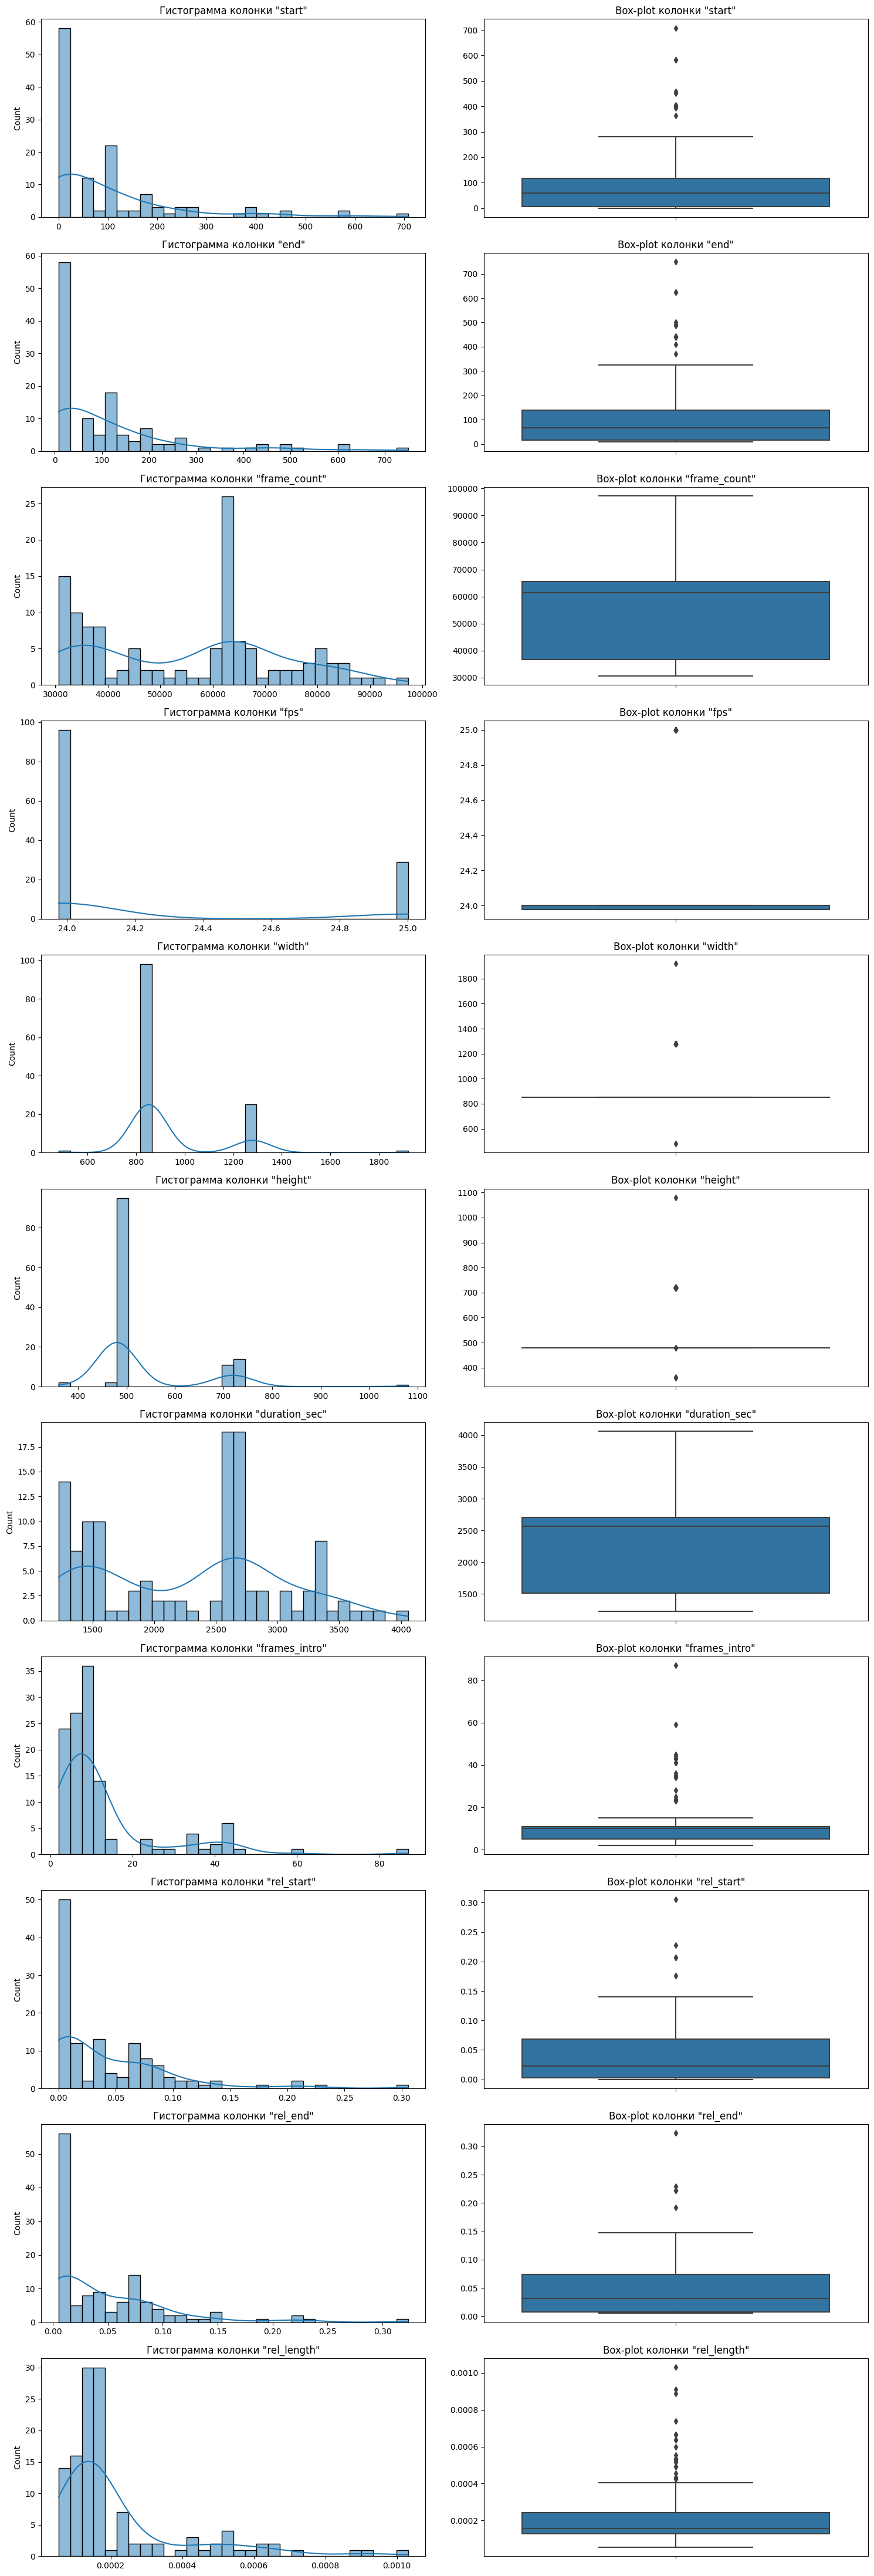

In [9]:
# выделим числовые характеристики и для них построим box plot, выделим значения с выбросами и сделаем выводы по поводу данных значений

# возникает warning связанный со значениями NaN в датафрейме, хотя их нет, решил, что его можно игнорировать
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

num_columns = ["start","end", "frame_count", "fps", "width", "height", "duration_sec", "frames_intro", "rel_start", "rel_end", "rel_length"]
df_numeric = df[num_columns]

n_cols = len(num_columns)
plt.figure(figsize=(15, 4 * n_cols))

# Проходим по всем колонкам
for i, column in enumerate(num_columns, 1):
    # Гистограммы
    plt.subplot(n_cols, 2, 2*i - 1)
    sns.histplot(df_numeric[column], bins=30, kde=True)
    plt.title(f'Гистограмма колонки "{column}"')
    plt.xlabel('')
    
    # Box-plots
    plt.subplot(n_cols, 2, 2*i)
    sns.boxplot(y=df_numeric[column])
    plt.title(f'Box-plot колонки "{column}"')
    plt.ylabel('')

plt.tight_layout()
plt.show()

# Выводы, которые можно сделать из гистограмм:

1) Несмотря на округление fps ранее в цикле с работой cv2, всего в видео пристутствуют 2 вида fps - 24 кадра в секунду и 25 кадров в секунду. Поэтому для упрощения дальнейшей работы будем преобразовывать видео в 20 кадров в секунду, 20 < 24 & 20 < 25, также так как 60 % 20 = 0, будем в итоге получать четкое рапределение кадр-время.
2) Минимальное время заставки 5-10 секунд, то есть, чтобы фрагмент видео являлся заставкой, как минимум 5-10 секунд подряд кадры должны обозначаться моделью нейросети как кадры заставки (это часть моего подхода, подробнее он описан в блокноте model_research.ipynb)
3) Ключевые инсайты - кадры заставки идут подряд, кадры не заставки тоже идут подряд, а также - заставка в видео всегда одна.
4) Минимальные высота и ширина кадра - 360 пикселей и 480 пикселей. Так как мой подход будет в себя включать нейросеть YOLOv11cls с максимальным форматом картинок в 224 на 224 пикселя, мы сможем все видео преобразовать к данному единому формату: 224 < 360 (сжатие по высоте) 224 < 480 (сжатие по ширине)
5) Значения для которых время заставки равно ~60 и ~80 секунд (2 конкретных значения) - являются выбросами, далее уберу их из датасета и в дальнейшем не буду их использовать при обучении.

In [10]:
df = df.loc[df["frames_intro"] < 50]
df_numeric = df[num_columns]

# Проанализируем связи между признаками

1. Корреляционная матрица
2. Диаграммы рассевания

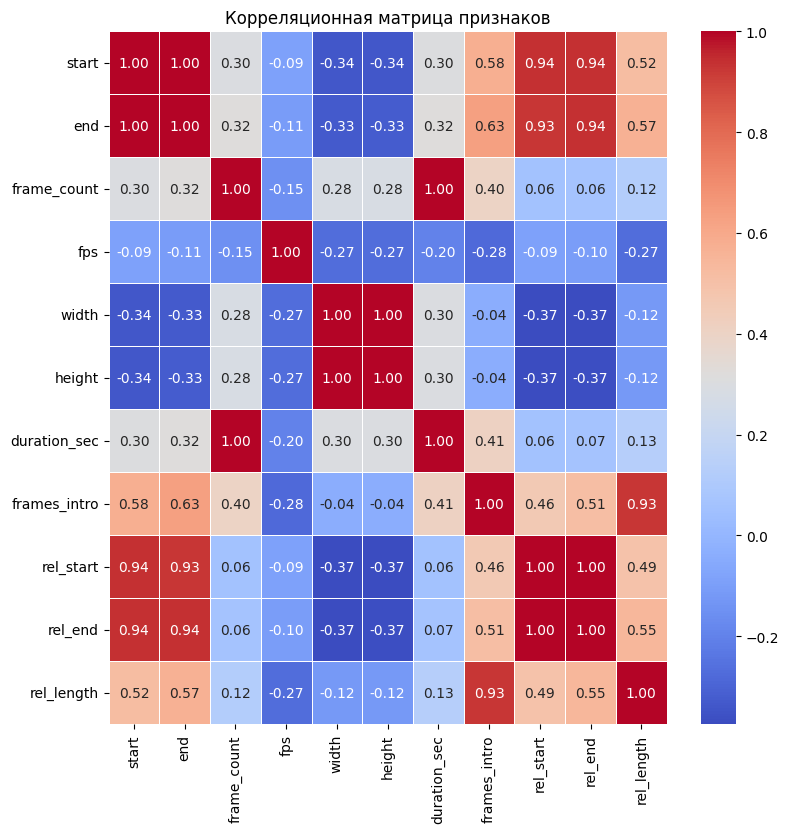

In [11]:
# Корреляционная матрица

plt.figure(figsize=(9, 9))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Корреляционная матрица признаков')
plt.show()

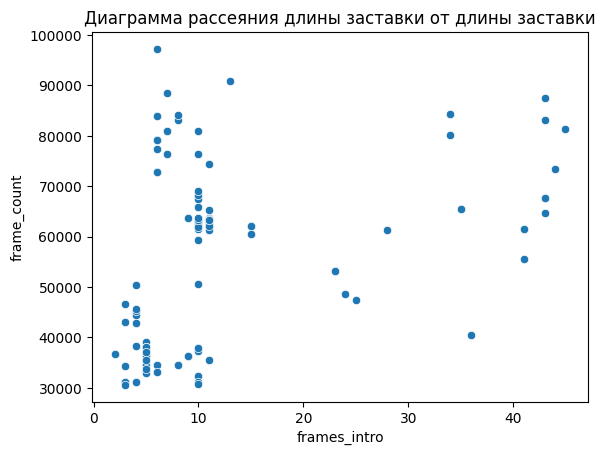

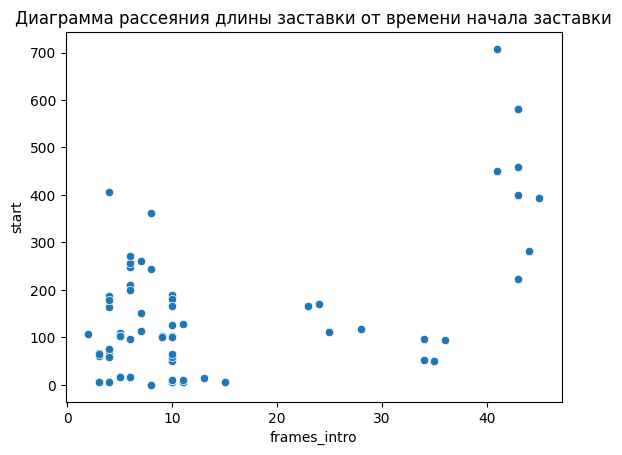

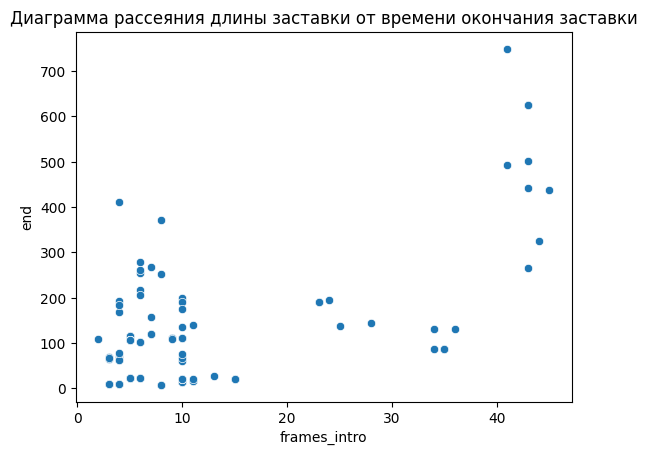

In [12]:
#Диаграммы рассеяния

sns.scatterplot(data=df_numeric, x='frames_intro', y='frame_count')
plt.title('Диаграмма рассеяния длины заставки от длины заставки')
plt.show()

sns.scatterplot(data=df_numeric, x='frames_intro', y='start')
plt.title('Диаграмма рассеяния длины заставки от времени начала заставки')
plt.show()

sns.scatterplot(data=df_numeric, x='frames_intro', y='end')
plt.title('Диаграмма рассеяния длины заставки от времени окончания заставки')
plt.show()

# Из исследования зависимостей признаков друг от друга, можно сделать выводы:

1. Есть слабая зависимость времени начала и времени окончания заставки от ее продолжительности - чем позже заставка, тем она длиннее.
2. Также есть слабая прямопропорциональная зависимость времени заставки от длины видео - чем больше длина видео, тем больше длина заставки
3. Апроксимация времени видео и/или времени начала/конца заставки на время заставки - маловероятна/не наглядна, реализовывать ее для проверки не будем.

# Результаты анализа далее будут использованы для обучения модели нейросети, в блокноте model_research.ipynb